### Train the model and view the result

### Visualize the iterative prediction process and draw dynamic graphs

loading data:  B0005.csv
loading data:  B0006.csv
loading data:  B0007.csv
loading data:  B0018.csv
151 151
151 151
151 151
115 115
(151, 10) (151, 8)
(151, 10) (151, 8)
(151, 10) (151, 8)
pred_y:  (115, 8)
error:  [0.00048377838285062395, 0.0005989006661677464, 0.0007229338923784707, 0.0006588190946562996, 0.0009254504272467462, 0.0011408403616642614, 0.00112915208980888, 0.0010148248958124916, 0.000675975165096173, 0.000517345148998005, 0.00036765149426166684, 0.0003024241976366832, 0.00025161542367029466, 0.00030144303686613155, 0.00037239231640990076, 0.0005834466448926723, 0.0007231928569343089, 0.0008887938721870104, 0.0010340000821367702, 0.0011788317674538812, 0.001325861079845995, 0.001280941799288987, 0.0010770496682213715, 0.0008050857497305341, 0.0006427780458791055, 0.0005031530445164549, 0.0004148077944926008, 0.00043703852437122683, 0.002261530530885821, 0.004303545947654329, 0.003111381397714738, 0.0037475480100187582, 0.004408510794027662, 0.005597912645872808, 0.00613

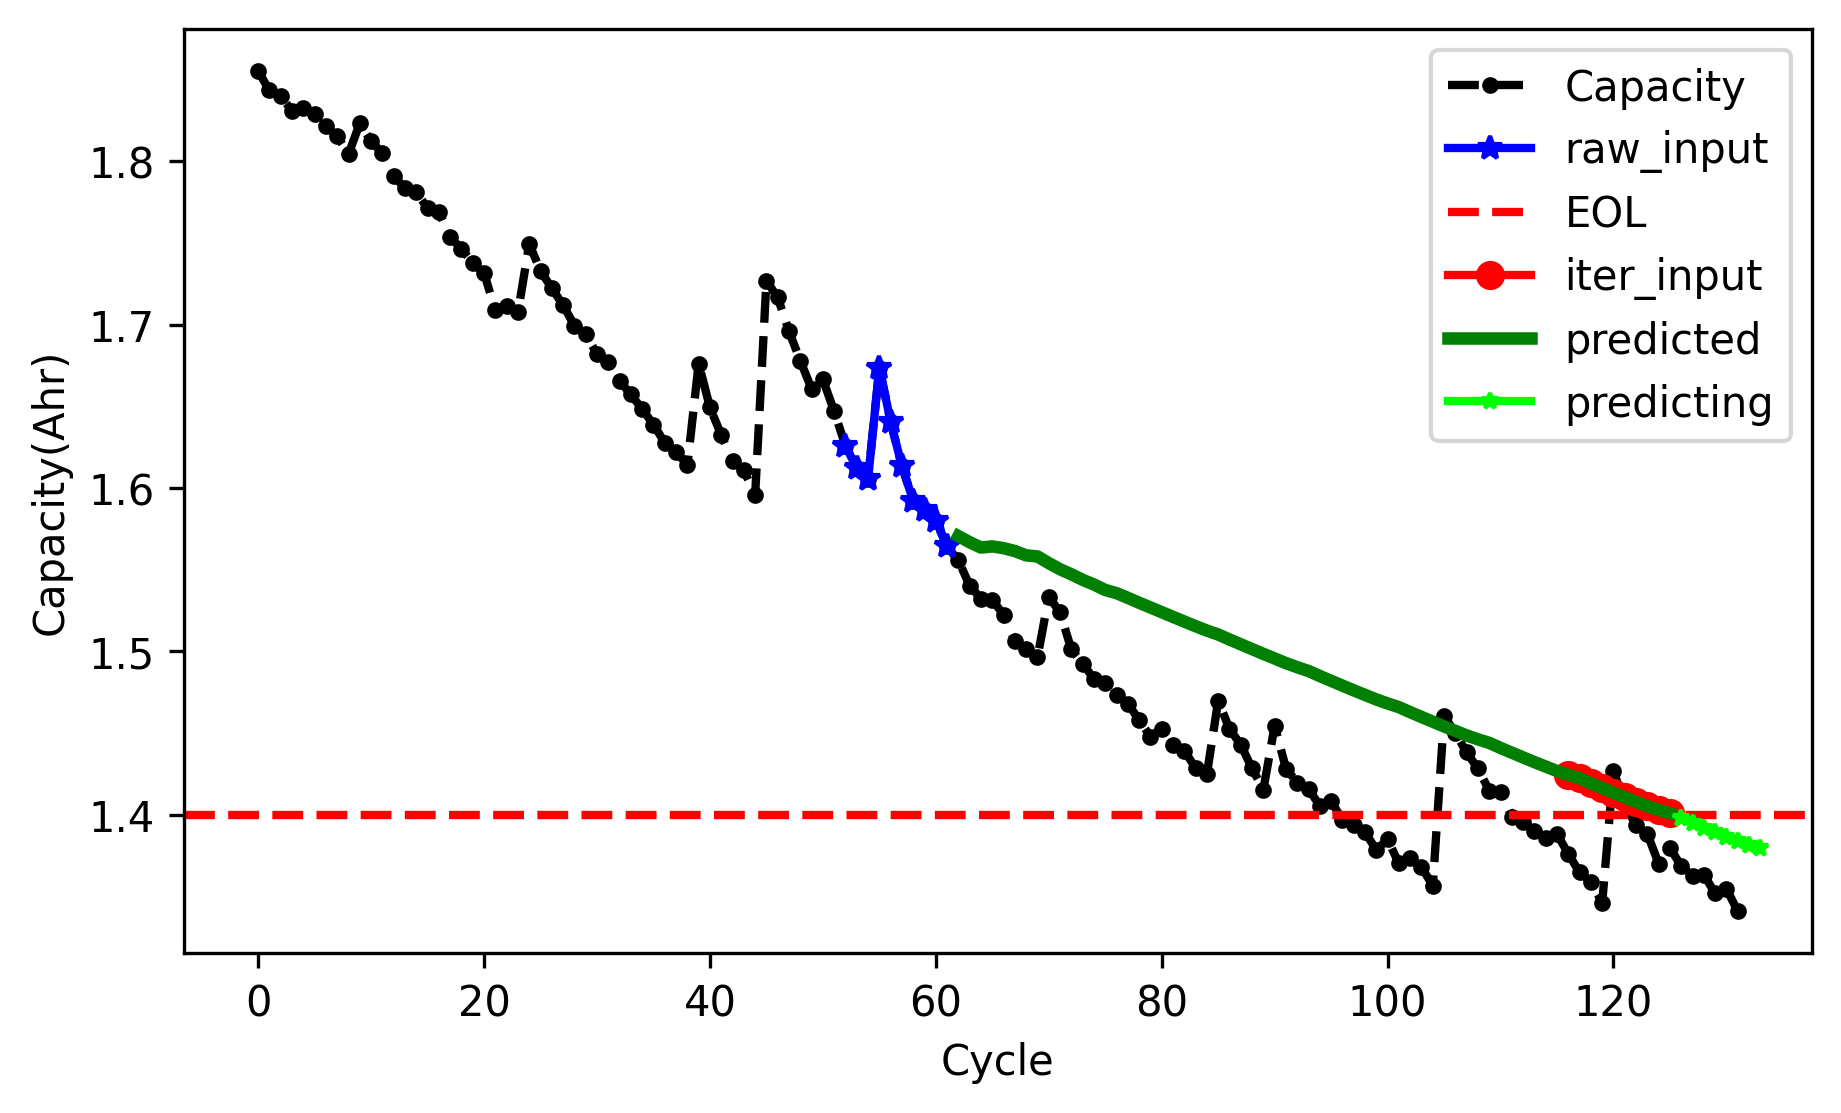

In [149]:
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.animation as animation

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
sklearn.utils.check_random_state(random_seed)


def build_model(model_name: str):
    model_dict = {
        'LR': 'from sklearn.linear_model import LinearRegression as Model',
        'GPR': 'from sklearn.gaussian_process import GaussianProcessRegressor as Model',
    }
    exec(model_dict[model_name])
    _model = eval("Model()")
    return _model

def build_criterion(criterion_name: str):
    crteria_dict = {
        'MSE': 'from sklearn.metrics import mean_squared_error as criterion',
        'RMSE': 'from sklearn.metrics import mean_squared_error as criterion',   # squared=False
        'MAE': 'from sklearn.metrics import mean_absolute_error as criterion',
    }

    exec(crteria_dict[criterion_name])
    _criterion = eval("criterion")
    # _criterion = eval("criterion()") if criterion_name not in ['RMSE'] else eval("criterion(squared=False)")
    return _criterion


seq_len, pred_len = 10, 8   # Time step of input and output
input_dim, output_dim = 1, 1 # Feature number of input and output
data_source = 'NASA' # 'NASA' or 'CMAPSS'
standard_flag = True # True or False

model_name = 'LR' # 'LR' or 'GPR'
criterion = 'RMSE' # 'MSE' or 'RMSE' or 'MAE'


data_path = {
    'NASA': 'data/NASA/',
}
data_list_npy = {
    'NASA': 'NASA',
}
data_list_csv = {
    'NASA': ['B0005', 'B0006', 'B0007', 'B0018'],
}


# Load data from csv-type file
data = []
for file_name in data_list_csv[data_source]:
    data.append(pd.read_csv(data_path[data_source]+file_name+'.csv').to_numpy())
    print('loading data: ', file_name+'.csv')

# # Load data from npy-type file
# data, data_temp = [], np.load(data_path[data_source]+data_list_npy[data_source]+'.npy', allow_pickle=True).item()
# for file_name in data_list_csv[data_source]:
#     data.append(np.array(data_temp[file_name]).transpose())
#     print('loading data: ', file_name+'.npy')


# Process data to RUL task
def process_data2RUL(data, seq_len, pred_len):
    data_x, data_y = [], []
    if seq_len == pred_len:
        for i in range(len(data)):
            data_temp = []
            for j in range(len(data[i])-2*seq_len+1):
                data_temp.append(data[i][j:j+seq_len, -1])
            data_x.append(data_temp[:-seq_len])
            data_y.append(data_temp[seq_len:])
            print(len(data_x[-1]), len(data_y[-1]))
    else:
        for i in range(len(data)):
            data_temp_x, data_temp_y = [], []
            for j in range(len(data[i])-seq_len-pred_len+1):
                data_temp_x.append(data[i][j:j+seq_len, -1])
                data_temp_y.append(data[i][j+seq_len:j+seq_len+pred_len, -1])
            data_x.append(data_temp_x)
            data_y.append(data_temp_y)
            print(len(data_x[-1]), len(data_y[-1]))

    return data_x, data_y

data_x, data_y = process_data2RUL(data, seq_len, pred_len)


# Split data into train and test set    # ['B0005.csv', 'B0006.csv', 'B0018.csv', 'B0007.csv']
# train_x, train_y = [np.array(data_x[i]) for i in [0,1,3]], [np.array(data_y[i]) for i in [0,1,3]]
# test_x, test_y = np.array(data_x[2]), np.array(data_y[2])
# real_capacity = data[2][:, -1]

train_x, train_y = [np.array(data_x[i]) for i in [0,1,2]], [np.array(data_y[i]) for i in [0,1,2]]
test_x, test_y = np.array(data_x[3]), np.array(data_y[3])
real_capacity = data[3][:, -1]

"""non-probability prediction"""
# LR预测结果
# Define model and fit data
model_name = 'LR'
model = build_model(model_name)
criterion = build_criterion(criterion)

for i in range(len(train_x)):
    print(train_x[i].shape, train_y[i].shape)
    model.fit(train_x[i], train_y[i])

# test
pred_y = model.predict(test_x)
print('pred_y: ', pred_y.shape)

# Calculate the error
error = []
for i in range(len(test_y)):
    error.append(criterion(test_y[i], pred_y[i]))
print('error: ', error)
print('mean error: ', np.mean(error))


def iterative_pred(model, input, EOL):
    # Iterative prediction
    input_list, pred_y = [input], []
    while True:
        pred_y.append(model.predict([input])[0])
        if all(pred_y[-1] > EOL):
            input = np.concatenate([input[len(pred_y[-1]):], pred_y[-1]])
            input_list.append(input)
        else:
            break
    # pred_y = np.concatenate(pred_y)
    return input_list, pred_y

class visual_iterative_pred():
    def __init__(self, model, input, start, EOL, real_capacity, ax):
        self.input_list, self.pred_y = iterative_pred(model, input, EOL)
        self.in_len, self.out_len, self.s = len(input), len(self.pred_y[0]), start
        capacity, = ax.plot(real_capacity, color='k', linewidth=2, markersize=3, marker='o', linestyle='dashed', label='Capacity')
        raw_input, = ax.plot(np.arange(self.s, self.s+len(input)), input, color='b', linewidth=2, marker='*', markersize=6, label='raw_input')
        EOL_im = ax.axhline(y=EOL, color='r', linestyle='dashed', linewidth=2, label='EOL')
        self.input_im, = ax.plot([], [], color='r', linewidth=2, marker='o', markersize=6, label='iter_input')
        self.predicted, = ax.plot([], [], color='green', linewidth=3, markersize=12, label='predicted')
        self.pred_im, = ax.plot(np.arange(self.s+self.in_len, self.out_len + self.s+self.in_len), self.pred_y[0],
                                color='lime', linewidth=2, marker='*', markersize=4, label='predicting')
        ax.legend()
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Capacity(Ahr)')
        self.ims = [capacity, raw_input, EOL_im, self.pred_im, self.input_im]

    def my_update(self, i):
        self.input_im.set_data(np.arange(self.s+i*8, self.s+i*8+self.in_len), self.input_list[i])
        self.pred_im.set_data(np.arange(self.s+i * self.out_len + self.in_len, self.s+(i + 1) * self.out_len + self.in_len),
                              self.pred_y[i])
        if i > 0:
            self.predicted.set_data(np.arange(self.s+self.in_len, self.s+i*self.out_len+self.in_len), np.concatenate(self.pred_y[:i]))

        return self.ims


fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
scope = visual_iterative_pred(model, test_x[52], 52, 1.4, real_capacity, ax)

# pass a generator in "emitter" to produce data for the update func
ani = animation.FuncAnimation(fig, scope.my_update, range(len(scope.pred_y)), interval=250, blit=True)
ani.save('dynamic52.gif', writer='pillow')

[[11.]
 [12.]
 [13.]
 [14.]
 [15.]
 [16.]
 [17.]
 [18.]
 [19.]
 [20.]]
[[21.]
 [22.]
 [23.]
 [24.]
 [25.]
 [26.]
 [27.]
 [28.]
 [29.]
 [30.]]
[[31.]
 [32.]
 [33.]
 [34.]
 [35.]
 [36.]
 [37.]
 [38.]
 [39.]
 [40.]]
[[41.]
 [42.]
 [43.]
 [44.]
 [45.]
 [46.]
 [47.]
 [48.]
 [49.]
 [50.]]
[[51.]
 [52.]
 [53.]
 [54.]
 [55.]
 [56.]
 [57.]
 [58.]
 [59.]
 [60.]]
[[61.]
 [62.]
 [63.]
 [64.]
 [65.]
 [66.]
 [67.]
 [68.]
 [69.]
 [70.]]
[[71.]
 [72.]
 [73.]
 [74.]
 [75.]
 [76.]
 [77.]
 [78.]
 [79.]
 [80.]]
[[81.]
 [82.]
 [83.]
 [84.]
 [85.]
 [86.]
 [87.]
 [88.]
 [89.]
 [90.]]
[[ 91.]
 [ 92.]
 [ 93.]
 [ 94.]
 [ 95.]
 [ 96.]
 [ 97.]
 [ 98.]
 [ 99.]
 [100.]]
[[101.]
 [102.]
 [103.]
 [104.]
 [105.]
 [106.]
 [107.]
 [108.]
 [109.]
 [110.]]
[[111.]
 [112.]
 [113.]
 [114.]
 [115.]
 [116.]
 [117.]
 [118.]
 [119.]
 [120.]]
[[121.]
 [122.]
 [123.]
 [124.]
 [125.]
 [126.]
 [127.]
 [128.]
 [129.]
 [130.]]
[[131.]
 [132.]
 [133.]
 [134.]
 [135.]
 [136.]
 [137.]
 [138.]
 [139.]
 [140.]]
[[141.]
 [142.]
 [143.]
 [1

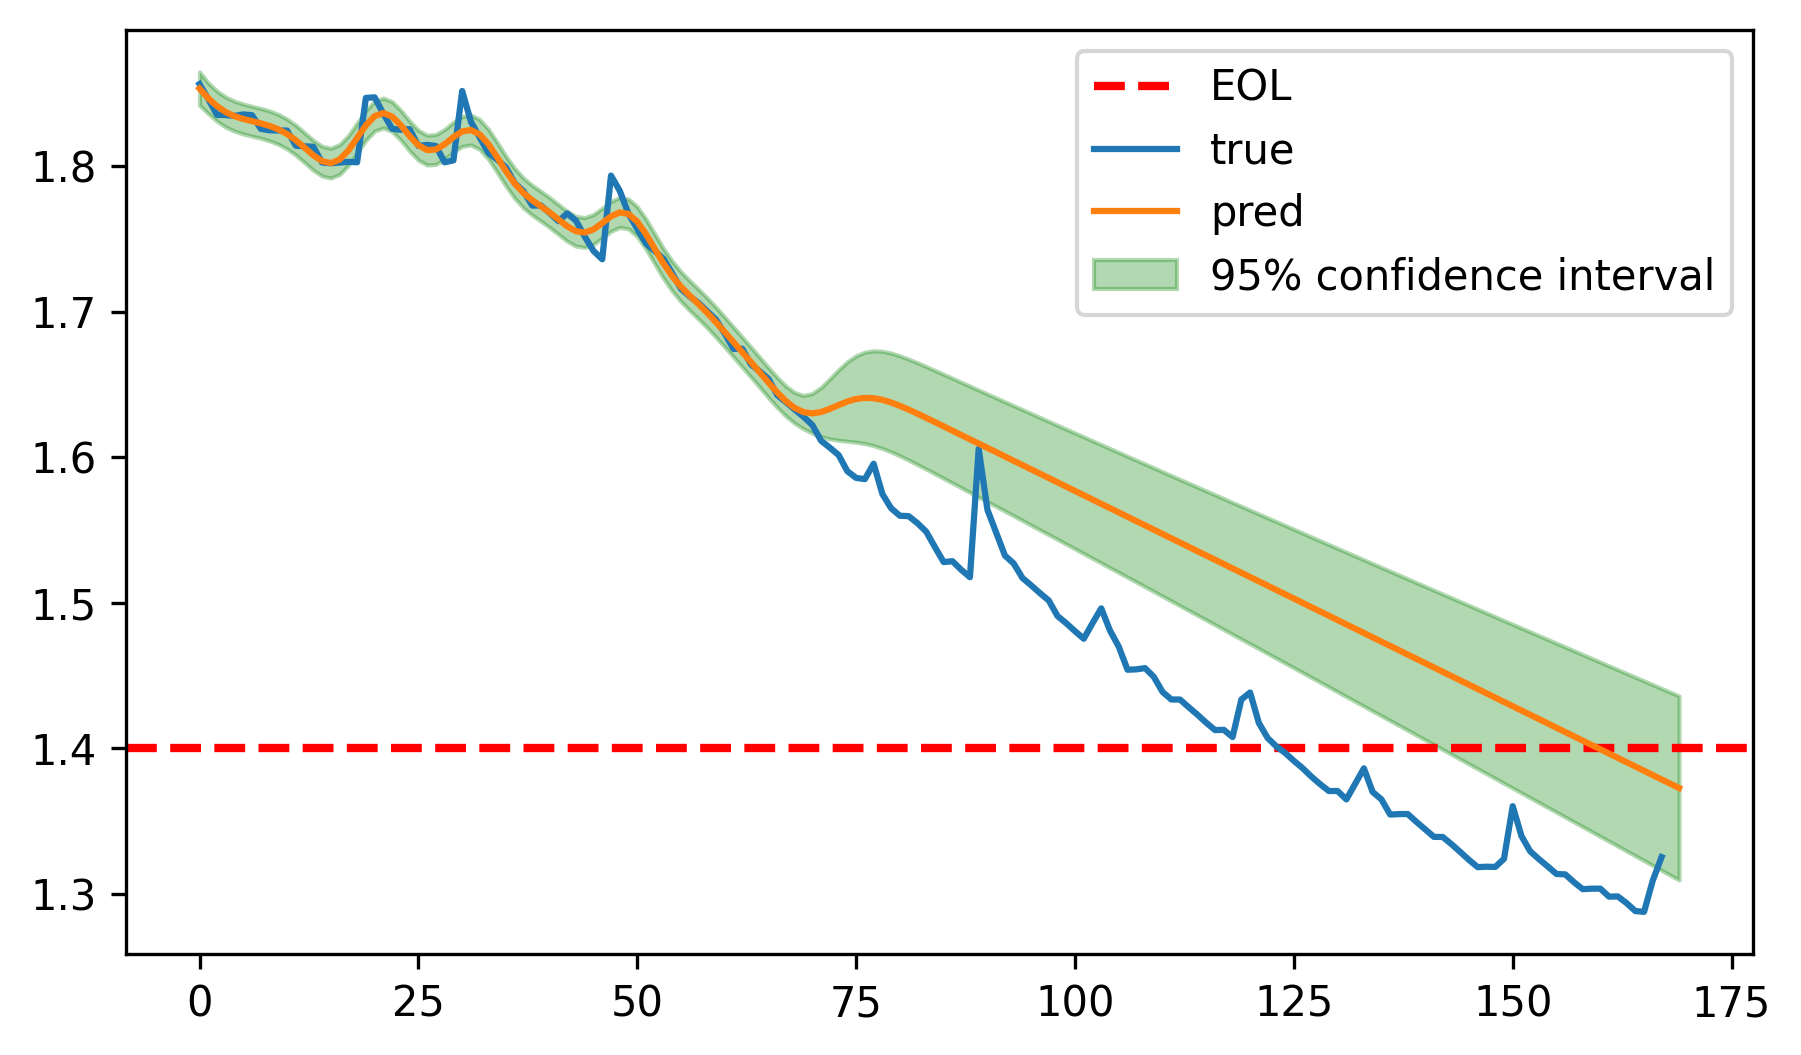

In [148]:
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.animation as animation

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
sklearn.utils.check_random_state(random_seed)

data = []
for file_name in ['B0005', 'B0006', 'B0007', 'B0018']:
    data.append(pd.read_csv('data/NASA/'+file_name+'.csv').to_numpy())


train_x, train_y = np.concatenate([data[1][:,0], data[2][:,0], data[3][:,0]]).reshape(-1,1), np.concatenate([data[1][:,1], data[2][:,1], data[3][:,1]]).reshape(-1,1)
test_x, test_y = data[0][:,0].reshape(-1,1), data[0][:,1].reshape(-1,1)

kernel = DotProduct() + WhiteKernel() + ConstantKernel() * RBF()
model = GaussianProcessRegressor(kernel=kernel, random_state=random_seed)
criterion = mean_squared_error

model.fit(train_x, train_y)
model.fit(test_x[:70], test_y[:70])
pred_mean, pred_std = [], []
count = 0
step = 10*np.ones((10,1))
input = test_x[:10]
while True:
    pred_y, pred_std_temp = model.predict(input, return_std=True)
    pred_mean.append(pred_y)
    pred_std.append(pred_std_temp)
    # if count>3:
    #     break
    if all(pred_y > 1.4):
        input = input + step
        print(input)
    else:
        break

pred_mean = np.concatenate(pred_mean)
pred_std = np.concatenate(pred_std)

plt.figure(figsize=(7, 4), dpi=300)
plt.axhline(y=1.4, color='r', linestyle='dashed', linewidth=2, label='EOL')
plt.plot(test_y, label='true')
plt.plot(pred_mean, label='pred')
plt.fill_between(np.arange(len(pred_mean)), pred_mean-pred_std, pred_mean+pred_std, color='green', alpha=0.3, label=r"95% confidence interval")
plt.legend()
plt.savefig('GPR.png', dpi=300)
plt.show()


loading data:  B0005.csv
loading data:  B0006.csv
loading data:  B0007.csv
loading data:  B0018.csv
151 151
151 151
151 151
115 115
(151, 10) (151, 8)


E:\RUL_venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(151, 10) (151, 8)


E:\RUL_venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(151, 10) (151, 8)


E:\RUL_venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


pred_y:  (115, 8)
error:  [0.010153387309884037, 0.011146559275559808, 0.01221496514396063, 0.013132031023473432, 0.014632822178643113, 0.01592429218328628, 0.017071781991610312, 0.01686697617627721, 0.01668134890413229, 0.016579646567493507, 0.016534322544040893, 0.016703528190557065, 0.016262279772195624, 0.016360956993257632, 0.016495655627287713, 0.018288205492439275, 0.019933052119738916, 0.0215994724785814, 0.023308210119828032, 0.025058307011147057, 0.026839347967172487, 0.02853133482574295, 0.027641422295462244, 0.027225832901879278, 0.027127583251904022, 0.02732361465870548, 0.027358739359893743, 0.027599284542265512, 0.023776663428425, 0.019831728738690053, 0.018665431882639374, 0.01703690215613431, 0.015239044465920221, 0.012712324134882626, 0.010519147664559445, 0.008323787966993727, 0.010369691473854263, 0.01242779763225481, 0.012319443557382015, 0.0125505936379037, 0.013119605747696135, 0.014496541864609174, 0.015541994477683865, 0.016184295415731596, 0.016971330150720363

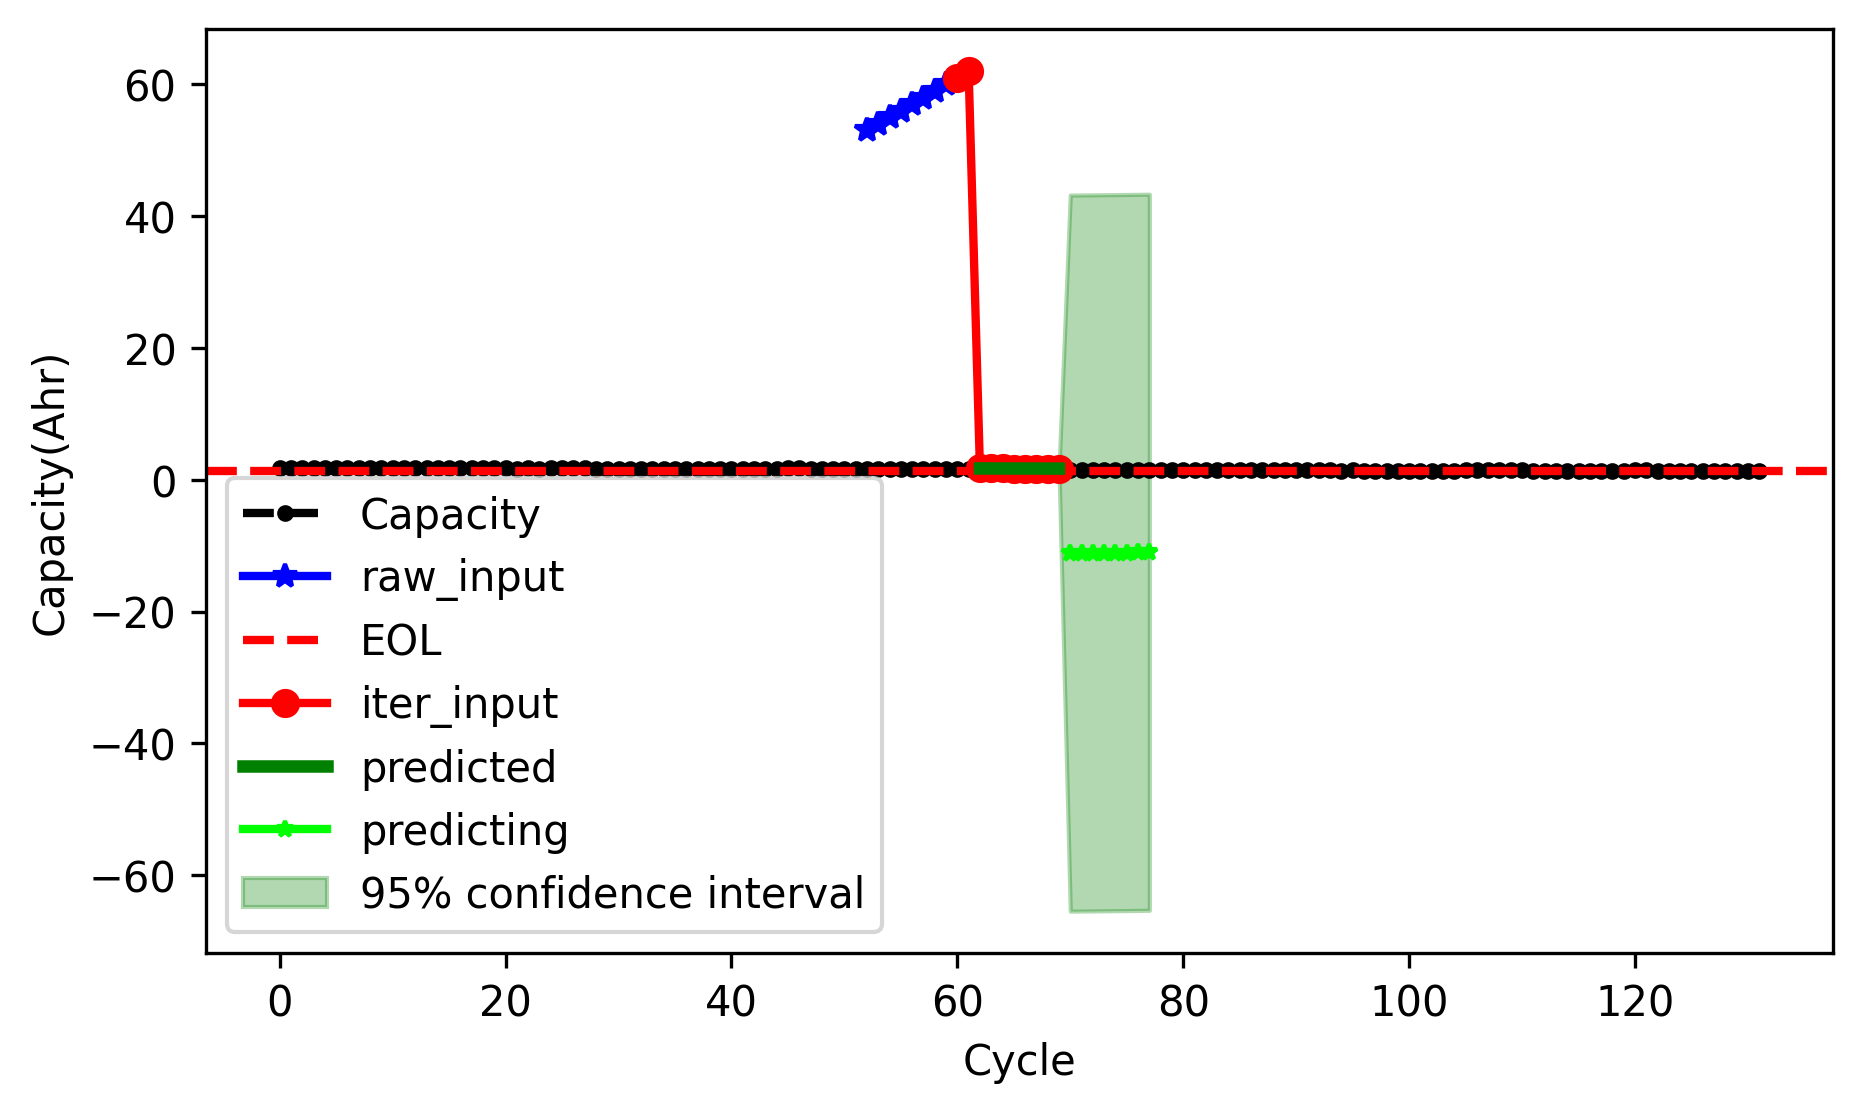

In [141]:
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.animation as animation

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
sklearn.utils.check_random_state(random_seed)


def build_model(model_name: str):
    model_dict = {
        'LR': 'from sklearn.linear_model import LinearRegression as Model',
        'GPR': 'from sklearn.gaussian_process import GaussianProcessRegressor as Model',
    }
    exec(model_dict[model_name])
    _model = eval("Model()")
    return _model

def build_criterion(criterion_name: str):
    crteria_dict = {
        'MSE': 'from sklearn.metrics import mean_squared_error as criterion',
        'RMSE': 'from sklearn.metrics import mean_squared_error as criterion',   # squared=False
        'MAE': 'from sklearn.metrics import mean_absolute_error as criterion',
    }

    exec(crteria_dict[criterion_name])
    _criterion = eval("criterion")
    # _criterion = eval("criterion()") if criterion_name not in ['RMSE'] else eval("criterion(squared=False)")
    return _criterion


seq_len, pred_len = 10, 8   # Time step of input and output
input_dim, output_dim = 1, 1 # Feature number of input and output
data_source = 'NASA' # 'NASA' or 'CMAPSS'
standard_flag = True # True or False

model_name = 'LR' # 'LR' or 'GPR'
criterion = 'RMSE' # 'MSE' or 'RMSE' or 'MAE'


data_path = {
    'NASA': 'data/NASA/',
}
data_list_npy = {
    'NASA': 'NASA',
}
data_list_csv = {
    'NASA': ['B0005', 'B0006', 'B0007', 'B0018'],
}


# Load data from csv-type file
data = []
for file_name in data_list_csv[data_source]:
    data.append(pd.read_csv(data_path[data_source]+file_name+'.csv').to_numpy())
    print('loading data: ', file_name+'.csv')

# # Load data from npy-type file
# data, data_temp = [], np.load(data_path[data_source]+data_list_npy[data_source]+'.npy', allow_pickle=True).item()
# for file_name in data_list_csv[data_source]:
#     data.append(np.array(data_temp[file_name]).transpose())
#     print('loading data: ', file_name+'.npy')


# Process data to RUL task
def process_data2RUL(data, seq_len, pred_len):
    data_x, data_y = [], []
    if seq_len == pred_len:
        for i in range(len(data)):
            data_temp = []
            for j in range(len(data[i])-2*seq_len+1):
                data_temp.append(data[i][j:j+seq_len, :])
            data_x.append(data_temp[:-seq_len, 0])
            data_y.append(data_temp[seq_len:, 1])
            print(len(data_x[-1]), len(data_y[-1]))
    else:
        for i in range(len(data)):
            data_temp_x, data_temp_y = [], []
            for j in range(len(data[i])-seq_len-pred_len+1):
                data_temp_x.append(data[i][j:j+seq_len, 0])
                data_temp_y.append(data[i][j+seq_len:j+seq_len+pred_len, -1])
            data_x.append(data_temp_x)
            data_y.append(data_temp_y)
            print(len(data_x[-1]), len(data_y[-1]))

    return data_x, data_y

data_x, data_y = process_data2RUL(data, seq_len, pred_len)


# Split data into train and test set    # ['B0005.csv', 'B0006.csv', 'B0018.csv', 'B0007.csv']
# train_x, train_y = [np.array(data_x[i]) for i in [0,1,3]], [np.array(data_y[i]) for i in [0,1,3]]
# test_x, test_y = np.array(data_x[2]), np.array(data_y[2])
# real_capacity = data[2][:, -1]

train_x, train_y = [np.array(data_x[i]) for i in [0,1,2]], [np.array(data_y[i]) for i in [0,1,2]]
test_x, test_y = np.array(data_x[3]), np.array(data_y[3])
real_capacity = data[3][:, -1]



"""probability prediction"""
# GPR测结果
# Define model and fit data
from sklearn.gaussian_process import GaussianProcessRegressor
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, random_state=random_seed)
criterion = build_criterion('MSE')

for i in range(len(train_x)):
    print(train_x[i].shape, train_y[i].shape)
    model.fit(train_x[i], train_y[i])

# test
pred_y = model.predict(test_x)
print('pred_y: ', pred_y.shape)

# Calculate the error
error = []
for i in range(len(test_y)):
    error.append(criterion(test_y[i], pred_y[i]))
print('error: ', error)
print('mean error: ', np.mean(error))


def iterative_pred(model, input, EOL):
    # Iterative prediction
    input_list, pred_mean, pred_std= [input], [], []
    while True:
        pred_mean.append(model.predict([input], return_std=True)[0][0])
        pred_std.append(model.predict([input], return_std=True)[1][0])
        if all(pred_mean[-1] > EOL):
            input = np.concatenate([input[len(pred_mean[-1]):], pred_mean[-1]])
            input_list.append(input)
        else:
            break
    # pred_y = np.concatenate(pred_y)
    return input_list, pred_mean, pred_std

class visual_iterative_pred():
    def __init__(self, model, input, start, EOL, real_capacity, ax):
        self.input_list, self.pred_mean, self.pred_std = iterative_pred(model, input, EOL)
        self.in_len, self.out_len, self.s = len(input), len(self.pred_mean[0]), start
        capacity, = ax.plot(real_capacity, color='k', linewidth=2, markersize=3, marker='o', linestyle='dashed', label='Capacity')
        raw_input, = ax.plot(np.arange(self.s, self.s+len(input)), input, color='b', linewidth=2, marker='*', markersize=6, label='raw_input')
        EOL_im = ax.axhline(y=EOL, color='r', linestyle='dashed', linewidth=2, label='EOL')
        self.input_im, = ax.plot([], [], color='r', linewidth=2, marker='o', markersize=6, label='iter_input')
        self.predicted, = ax.plot([], [], color='green', linewidth=3, markersize=12, label='predicted')
        self.pred_im, = ax.plot(np.arange(self.s+self.in_len, self.out_len + self.s+self.in_len), self.pred_mean[0], color='lime', linewidth=2, marker='*', markersize=4, label='predicting')
        self.fill = ax.fill_between(np.arange(self.s+self.in_len, self.out_len + self.s+self.in_len),
                                    self.pred_mean[0]-self.pred_std[0], self.pred_mean[0]+self.pred_std[0], color='green', alpha=0.3, label=r"95% confidence interval")
        ax.legend()
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Capacity(Ahr)')
        self.ims = [capacity, raw_input, EOL_im, self.fill, self.pred_im, self.input_im]

    def my_update(self, i):
        self.input_im.set_data(np.arange(self.s+i*8, self.s+i*8+self.in_len), self.input_list[i])
        self.pred_im.set_data(np.arange(self.s+i * self.out_len + self.in_len, self.s+(i + 1) * self.out_len + self.in_len), self.pred_mean[i])
        if i > 0:
            self.predicted.set_data(np.arange(self.s+self.in_len, self.s+i*self.out_len+self.in_len), np.concatenate(self.pred_mean[:i]))
            if i < len(self.pred_mean):
                self.fill.remove()
                mean = np.concatenate(self.pred_mean[:i+1])
                std =  np.concatenate(self.pred_std[:i+1])
                # print(mean.shape, std.shape)
                # print(np.arange(self.s+self.in_len, self.s+(i + 1) * self.out_len + self.in_len).shape)
                self.fill = ax.fill_between(np.arange(self.s+self.in_len, self.s+(i + 1) * self.out_len + self.in_len), mean-std, mean+std, color='green', alpha=0.3, label=r"95% confidence interval")

        return self.ims


fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
scope = visual_iterative_pred(model, test_x[52], 52, 1.4, real_capacity, ax)

# pass a generator in "emitter" to produce data for the update func
ani = animation.FuncAnimation(fig, scope.my_update, range(len(scope.pred_mean)), interval=250, blit=True)
ani.save('dynamic_GPR_.gif', writer='pillow')

loading data:  B0005.csv
loading data:  B0006.csv
loading data:  B0007.csv
loading data:  B0018.csv
151 151
151 151
151 151
115 115
(151, 10) (151, 8)


E:\RUL_venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\RUL_venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(151, 10) (151, 8)
(151, 10) (151, 8)


E:\RUL_venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


pred_y:  (115, 8)
error:  [0.0003649010031230093, 0.0005363914468550425, 0.0007339779865224115, 0.0008257018414749338, 0.001135212823343915, 0.0013383568798891916, 0.001430910345692966, 0.0012667731384784905, 0.0010038849283927657, 0.0008144837259537563, 0.000593845339118624, 0.00047192419366971625, 0.0002466652446128015, 0.0002474527538539205, 0.00028559684025115765, 0.00033268554661821065, 0.000548784680307213, 0.0007824509625280869, 0.0010356965009669906, 0.0012695153693439301, 0.0015102689566027228, 0.0016541521851708946, 0.0014732883863723385, 0.0012222284226461274, 0.0010385441339836486, 0.0007944828096259588, 0.0006062712947994867, 0.000519620784696716, 0.0019330057821368583, 0.00354551709848607, 0.003678968510805276, 0.0040854008996266825, 0.004513034078805217, 0.005287978468690436, 0.005893371815350469, 0.0066580741051781595, 0.0023358275355680105, 0.0006746090901023561, 0.0005575074999103021, 0.0005296128762293445, 0.0005751120938911549, 0.0008345196628479418, 0.0010684886790

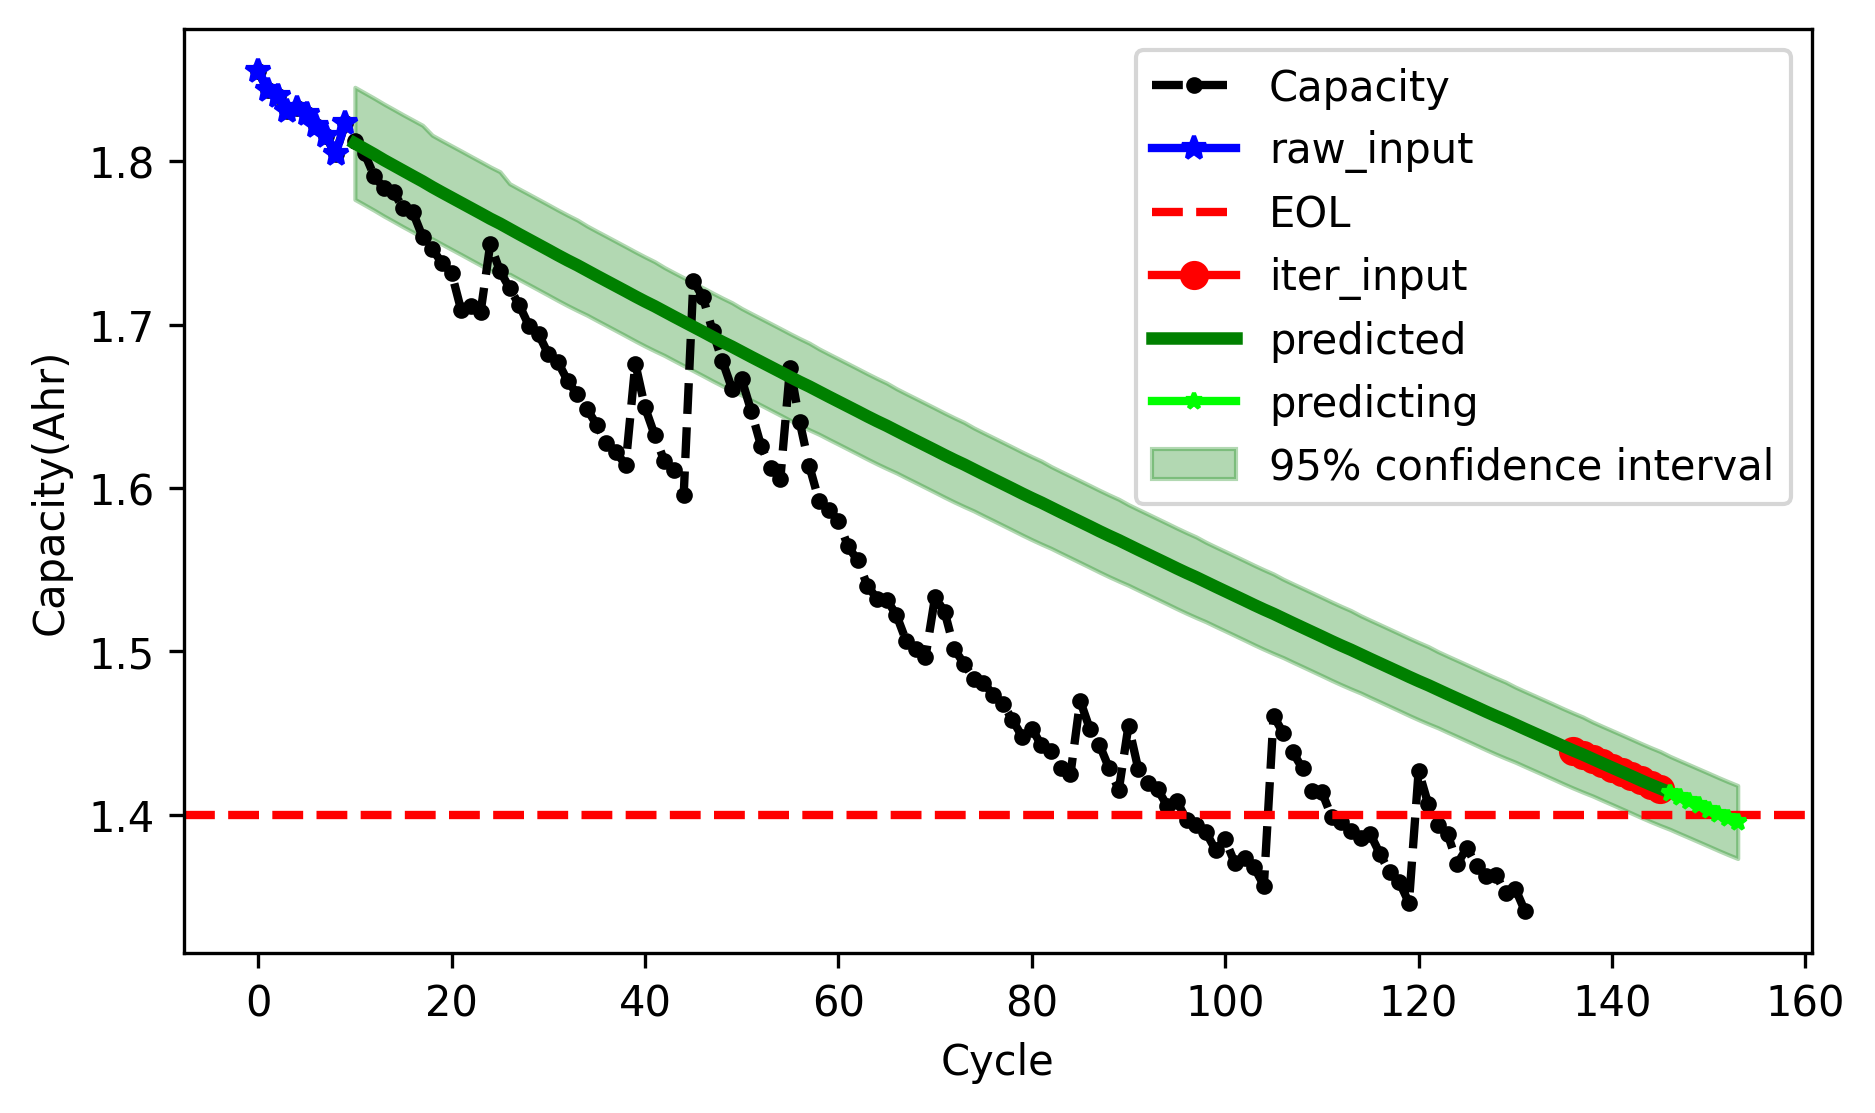

In [122]:
import random
import numpy as np
import pandas as pd
import sklearn
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.animation as animation

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
sklearn.utils.check_random_state(random_seed)


def build_model(model_name: str):
    model_dict = {
        'LR': 'from sklearn.linear_model import LinearRegression as Model',
        'GPR': 'from sklearn.gaussian_process import GaussianProcessRegressor as Model',
    }
    exec(model_dict[model_name])
    _model = eval("Model()")
    return _model

def build_criterion(criterion_name: str):
    crteria_dict = {
        'MSE': 'from sklearn.metrics import mean_squared_error as criterion',
        'RMSE': 'from sklearn.metrics import mean_squared_error as criterion',   # squared=False
        'MAE': 'from sklearn.metrics import mean_absolute_error as criterion',
    }

    exec(crteria_dict[criterion_name])
    _criterion = eval("criterion")
    # _criterion = eval("criterion()") if criterion_name not in ['RMSE'] else eval("criterion(squared=False)")
    return _criterion


seq_len, pred_len = 10, 8   # Time step of input and output
input_dim, output_dim = 1, 1 # Feature number of input and output
data_source = 'NASA' # 'NASA' or 'CMAPSS'
standard_flag = True # True or False

model_name = 'LR' # 'LR' or 'GPR'
criterion = 'RMSE' # 'MSE' or 'RMSE' or 'MAE'


data_path = {
    'NASA': 'data/NASA/',
}
data_list_npy = {
    'NASA': 'NASA',
}
data_list_csv = {
    'NASA': ['B0005', 'B0006', 'B0007', 'B0018'],
}


# Load data from csv-type file
data = []
for file_name in data_list_csv[data_source]:
    data.append(pd.read_csv(data_path[data_source]+file_name+'.csv').to_numpy())
    print('loading data: ', file_name+'.csv')

# # Load data from npy-type file
# data, data_temp = [], np.load(data_path[data_source]+data_list_npy[data_source]+'.npy', allow_pickle=True).item()
# for file_name in data_list_csv[data_source]:
#     data.append(np.array(data_temp[file_name]).transpose())
#     print('loading data: ', file_name+'.npy')


# Process data to RUL task
def process_data2RUL(data, seq_len, pred_len):
    data_x, data_y = [], []
    if seq_len == pred_len:
        for i in range(len(data)):
            data_temp = []
            for j in range(len(data[i])-2*seq_len+1):
                data_temp.append(data[i][j:j+seq_len, -1])
            data_x.append(data_temp[:-seq_len])
            data_y.append(data_temp[seq_len:])
            print(len(data_x[-1]), len(data_y[-1]))
    else:
        for i in range(len(data)):
            data_temp_x, data_temp_y = [], []
            for j in range(len(data[i])-seq_len-pred_len+1):
                data_temp_x.append(data[i][j:j+seq_len, -1])
                data_temp_y.append(data[i][j+seq_len:j+seq_len+pred_len, -1])
            data_x.append(data_temp_x)
            data_y.append(data_temp_y)
            print(len(data_x[-1]), len(data_y[-1]))

    return data_x, data_y

data_x, data_y = process_data2RUL(data, seq_len, pred_len)


# Split data into train and test set    # ['B0005.csv', 'B0006.csv', 'B0018.csv', 'B0007.csv']
# train_x, train_y = [np.array(data_x[i]) for i in [0,1,3]], [np.array(data_y[i]) for i in [0,1,3]]
# test_x, test_y = np.array(data_x[2]), np.array(data_y[2])
# real_capacity = data[2][:, -1]

train_x, train_y = [np.array(data_x[i]) for i in [0,1,2]], [np.array(data_y[i]) for i in [0,1,2]]
test_x, test_y = np.array(data_x[3]), np.array(data_y[3])
real_capacity = data[3][:, -1]



"""probability prediction"""
# GPR测结果
# Define model and fit data
from sklearn.gaussian_process import GaussianProcessRegressor
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=2, random_state=random_seed)
criterion = build_criterion('MSE')

for i in range(len(train_x)):
    print(train_x[i].shape, train_y[i].shape)
    model.fit(train_x[i], train_y[i])

# test
pred_y = model.predict(test_x)
print('pred_y: ', pred_y.shape)

# Calculate the error
error = []
for i in range(len(test_y)):
    error.append(criterion(test_y[i], pred_y[i]))
print('error: ', error)
print('mean error: ', np.mean(error))


def iterative_pred(model, input, EOL):
    # Iterative prediction
    input_list, pred_mean, pred_std= [input], [], []
    while True:
        mean, std = model.predict([input], return_std=True)
        pred_mean.append(mean[0])
        pred_std.append(std[0])
        if all(pred_mean[-1] > EOL):
            input = np.concatenate([input[len(pred_mean[-1]):], pred_mean[-1]])
            input_list.append(input)
        else:
            break
    # pred_y = np.concatenate(pred_y)
    return input_list, pred_mean, pred_std

class visual_iterative_pred():
    def __init__(self, model, input, start, EOL, real_capacity, ax):
        self.input_list, self.pred_mean, self.pred_std = iterative_pred(model, input, EOL)
        self.in_len, self.out_len, self.s = len(input), len(self.pred_mean[0]), start
        capacity, = ax.plot(real_capacity, color='k', linewidth=2, markersize=3, marker='o', linestyle='dashed', label='Capacity')
        raw_input, = ax.plot(np.arange(self.s, self.s+len(input)), input, color='b', linewidth=2, marker='*', markersize=6, label='raw_input')
        EOL_im = ax.axhline(y=EOL, color='r', linestyle='dashed', linewidth=2, label='EOL')
        self.input_im, = ax.plot([], [], color='r', linewidth=2, marker='o', markersize=6, label='iter_input')
        self.predicted, = ax.plot([], [], color='green', linewidth=3, markersize=12, label='predicted')
        self.pred_im, = ax.plot(np.arange(self.s+self.in_len, self.out_len + self.s+self.in_len), self.pred_mean[0], color='lime', linewidth=2, marker='*', markersize=4, label='predicting')
        self.fill = ax.fill_between(np.arange(self.s+self.in_len, self.out_len + self.s+self.in_len),
                                    self.pred_mean[0]-self.pred_std[0], self.pred_mean[0]+self.pred_std[0], color='green', alpha=0.3, label=r"95% confidence interval")
        ax.legend()
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Capacity(Ahr)')
        self.ims = [capacity, raw_input, EOL_im, self.fill, self.pred_im, self.input_im]

    def my_update(self, i):
        self.input_im.set_data(np.arange(self.s+i*8, self.s+i*8+self.in_len), self.input_list[i])
        self.pred_im.set_data(np.arange(self.s+i * self.out_len + self.in_len, self.s+(i + 1) * self.out_len + self.in_len), self.pred_mean[i])
        if i > 0:
            self.predicted.set_data(np.arange(self.s+self.in_len, self.s+i*self.out_len+self.in_len), np.concatenate(self.pred_mean[:i]))
            if i < len(self.pred_mean):
                self.fill.remove()
                mean = np.concatenate(self.pred_mean[:i+1])
                std =  np.concatenate(self.pred_std[:i+1])
                # print(mean.shape, std.shape)
                # print(np.arange(self.s+self.in_len, self.s+(i + 1) * self.out_len + self.in_len).shape)
                self.fill = ax.fill_between(np.arange(self.s+self.in_len, self.s+(i + 1) * self.out_len + self.in_len), mean-std, mean+std, color='green', alpha=0.3, label=r"95% confidence interval")

        return self.ims


fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
scope = visual_iterative_pred(model, test_x[0], 0, 1.4, real_capacity, ax)

# pass a generator in "emitter" to produce data for the update func
ani = animation.FuncAnimation(fig, scope.my_update, range(len(scope.pred_mean)), interval=250, blit=True)
ani.save('dynamic_GPR_0.gif', writer='pillow')